In [1]:
import random
import gym
import numpy as np
from collections import deque
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

2024-03-23 23:26:09.865467: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 23:26:09.868638: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-23 23:26:09.911013: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-23 23:26:10.560376: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
EPISODES = 1000

In [3]:
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95    # discount rate
        self.epsilon = 1.0  # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self._build_model()

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(24, input_dim=self.state_size, activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',
                      optimizer=Adam(learning_rate=self.learning_rate))
        return model

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action

    def replay(self, batch_size):
        minibatch = random.sample(self.memory, batch_size)
        states, targets_f = [], []
        for state, action, reward, next_state, done in minibatch:
            target = reward     # Target = 1 OR -10
            if not done:
                target = (reward + self.gamma *     # New Q value [state, action] = Current Reward + decay * next best action
                          np.amax(self.model.predict(next_state)[0]))
            target_f = self.model.predict(state)
            target_f[0][action] = target            # Target[left/right] = New Q value
            # Filtering out states and targets for training
            states.append(state[0])                 # Input State for New Q value
            targets_f.append(target_f[0])           # [1, 2, 3, 4] -> [target, arbitrary]

        history = self.model.fit(np.array(states), np.array(targets_f), epochs=1, verbose=1)
        # Keeping track of loss
        loss = history.history['loss'][0]
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        return loss

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)

In [4]:
"""
    state_size  : 4 : (Cart Position, Cart Velocity, Angle of Pole, Pole's Angular Velocity)
    action_size : 2 : (Left or Right) (0, 1)
"""
env = gym.make('CartPole-v1')
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
agent = DQNAgent(state_size, action_size)
done = False
batch_size = 32

/home/abdul-rehman/DISK-W/python/work-env/myvnv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
! pip install pydot

/home/abdul-rehman/DISK-W/python/work-env/myvnv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


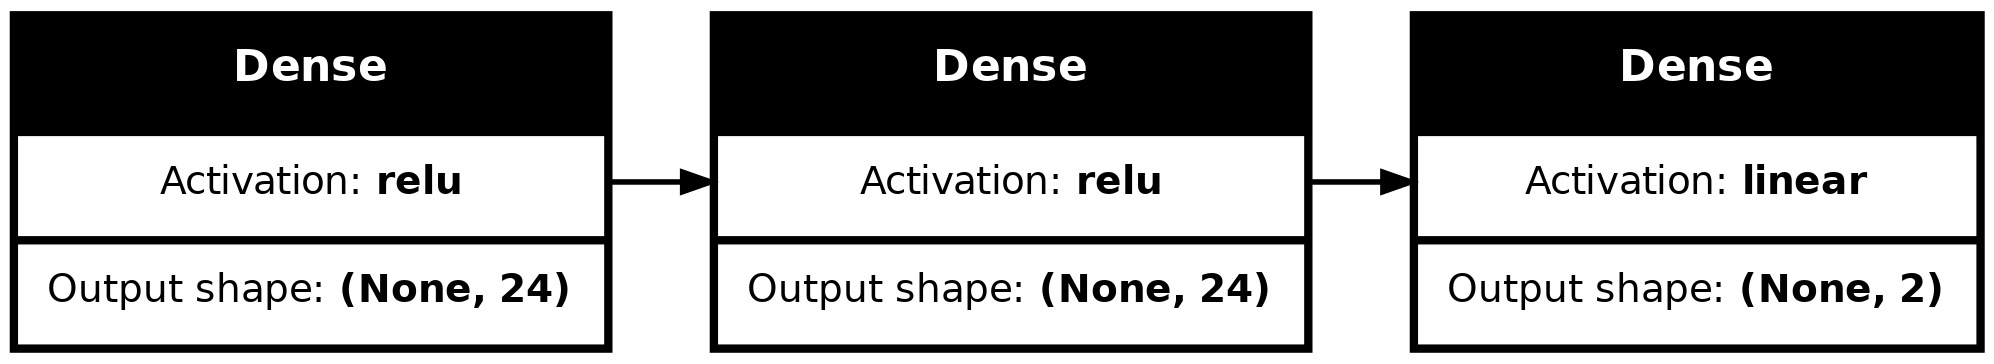

In [11]:
from keras.utils import plot_model

model = agent._build_model()
plot_model(model, to_file='./model_plot.png', show_shapes=True, show_layer_activations=True, rankdir="LR",)

## Reinforcement Learning

1. For Each Episode, we are iterating 500 times. 
2. For each time, 
3. We calculate Q Values for Input States
4. Input State becomes Features, Actions become targets
5. Q value calucated by Bellman Equation becomes target for this exploration or explitation timestep
6. If the memory sample increases batch size, we train the model on memory data
7. For first model.replay, no. of examples = 32, for 2nd, 32* 3, and so on
8. The Q-value for a state-action pair (s, a) represents the expected cumulative reward when taking action a in state s 
9. Neural network is trained to minimize the error between Predicted Actopms and target Q-values.
10. After training, model learns to map the action to states

In [126]:
state = env.reset() 
state = np.reshape(state[0], [1, state_size])
agent.act(state)

0

In [131]:
for e in range(EPISODES):
    state = env.reset() 
    state = np.reshape(state[0], [1, state_size])  # Probability Distribution (1, 4)
    for time in range(500):
        # env.render()
        action = agent.act(state)
        next_state, reward, done, _, _ = env.step(action)

        # -10 provides a strong disincentive to the agent to end an episode early
        # by losing control of balancing the pole or navigating off the screen                                                   
        reward = reward if not done else -10        

        next_state = np.reshape(next_state, [1, state_size])
        agent.memorize(state, action, reward, next_state, done)
        state = next_state
        if done:
            print("episode: {}/{}, score: {}, e: {:.2}"
                    .format(e, EPISODES, time, agent.epsilon))
            break
        if len(agent.memory) > batch_size:
            loss = agent.replay(batch_size)
            # Logging training loss every 10 timesteps
            if time % 10 == 0:
                print("episode: {}/{}, time: {}, loss: {:.4f}"
                    .format(e, EPISODES, time, loss))  
    # if e % 10 == 0:
    #     agent.save("./save/cartpole-dqn.h5")

0
